### Recommendation System on Amazon SageMaker - Beginner (Factorization Machine)

이 노트북에서는 Amazon Sagemaker를 사용하여 Factorization machine 으로 간단한 영화 추천 모델을 구축합니다.

SageMaker built-in 알고리즘으로서의 Factorization machine 에 대한 자세한 정보는 [여기](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines.html) 에서 확인하실 수 있습니다.

### Factorization Machine
https://supkoon.tistory.com/31  
Factorization Machine (FM) 은 2010년에 도입된 지도 학습 기술입니다 ([연구 논문](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)). FM은 행렬 인수 분해를 통해 문제 차원을 줄이는 능력에서 이름을 얻었습니다.

FM 은 분류 또는 회귀에 사용할 수 있으며 대규모 희소 데이터 세트에서 선형 회귀와 같은 기존 알고리즘보다 훨씬 계산 효율적입니다. 바로 이 속성이 FM 이 추천을 위해 널리 사용되는 이유입니다. 실제 추천 수는 매우 적지 만 사용자 수와 항목 수는 일반적으로 매우 큽니다 (사용자가 사용 가능한 모든 아이템을 평가하지는 않음).

다음은 FM 이 데이터셋에서 어떻게 피쳐 벡터가 생성되는지를 보여주는 간단한 예입니다. 한 행(row) 에는 하나의 user 와 movie 에 대한 정보가 들어가 있는것을 확인할 수 있습니다. 각 영화 섹션에 대한 평점은 (주황색, 노랑색, 빨간색) 각 열의 합이 1이 되도록 Normalize 되어 있습니다. 마지막 Last movie rated 섹션은 주황색 섹션의 평점 바로 이전에 평점을 준 아이템이 무엇인지 알려줍니다.

<!-- ![image](https://yudong-public-data.s3.ap-northeast-2.amazonaws.com/imgs/fm/fm.jpeg) -->

<div>
<img src="fm.png"/>
</div>

### Preparation

In [1]:
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import json_deserializer

import boto3, csv, io, json
import numpy as np
from scipy.sparse import lil_matrix

In [2]:
sess   = sagemaker.Session()
bucket = sess.default_bucket()                     
prefix = 'sagemaker/movielens'
region = boto3.Session().region_name

In [3]:
role = sagemaker.get_execution_role()

In [4]:
print('Sagemaker session :', sess)
print('S3 bucket :', bucket)
print('Prefix :', prefix)
print('Region selected :', region)
print('IAM role :', role)

Sagemaker session : <sagemaker.session.Session object at 0x7f3826b2c910>
S3 bucket : sagemaker-us-east-1-654304825407
Prefix : sagemaker/movielens
Region selected : us-east-1
IAM role : arn:aws:iam::654304825407:role/service-role/AmazonSageMaker-ExecutionRole-20230515T214643


### Build training set and test set

In [5]:
nbUsers=943
nbMovies=1682
nbFeatures=nbUsers+nbMovies

nbRatingsTrain=90570
nbRatingsTest=9430

### Dataset - MovieLens

이 데이터 셋은 추천 시스템에 사용되기 좋은 데이터 셋입니다. 다양한 크기로 제공되는데 이 예제에서는 ml100k: 1682편의 영화에서 943명의 사용자가 제공하는 100,000개의 평점을 사용할 것입니다. 보시다시피 ml100k 등급 행렬은 가능한 1,586,126 (943 by 1682) 중 100,000개의 등급만 보유하기 때문에 매우 스파스되어 있습니다. (정확하게는 93.6%).

다음은 데이터 세트의 처음 10개 줄입니다. 예를 들면, 사용자 754가 영화 595에 2성급 등급을 부여했습니다.


| user id | movie id | rating | timestamp |
| :--- | :--- | :--- | :--- |
| 754 |       595 |        2        |     879452073 |
| 932 |         157 |         4 |             891250667 |
|751|         100|         4|             889132252|
|101|         820|         3|             877136954|
|606|         1277|      3|             878148493|
|581|         475 |        4|             879641850|
|13|           50|           5|             882140001|
|457|         59|           5|             882397575|
|111|         321|         3|             891680076|
|123|         657|         4|             879872066|


In [6]:
!mkdir -p data

In [7]:
%%bash

curl -o data/ml-100k.zip http://files.grouplens.org/datasets/movielens/ml-100k.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  11.7M      0 --:--:-- --:--:-- --:--:-- 11.7M


In [8]:
!cd data && unzip -o ml-100k.zip

Archive:  ml-100k.zip
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [9]:
!rm data/ml-100k.zip

#### Explore data using pandas

In [10]:
import pandas as pd

In [11]:
raw_df = pd.read_csv('./data/ml-100k/ua.base', delimiter='\t', names=["user-id", "movie-id", "rating", "timestamp"])

In [12]:
raw_df

,user-id,movie-id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
...,...,...,...,...
90565,943,1047,2,875502146
90566,943,1074,4,888640250
90567,943,1188,3,888640250
90568,943,1228,3,888640275


In [13]:
# pass in column names for each CSV
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('./data/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('./data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

# create one merged DataFrame
movie_ratings = pd.merge(movies, ratings)
lens = pd.merge(movie_ratings, users)

In [14]:
lens.head(5)

,movie_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp,age,sex,occupation,zip_code
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532,60,M,retired,95076
1,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,308,5,887737890,60,M,retired,95076
2,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),308,4,887739608,60,M,retired,95076
3,7,Twelve Monkeys (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Twelve%20Monk...,308,4,887738847,60,M,retired,95076
4,8,Babe (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Babe%20(1995),308,5,887736696,60,M,retired,95076


In [15]:
most_rated = lens.groupby('title').size().sort_values(ascending=False)[:25]
most_rated

title
Star Wars (1977)                             583
Contact (1997)                               509
Fargo (1996)                                 508
Return of the Jedi (1983)                    507
Liar Liar (1997)                             485
English Patient, The (1996)                  481
Scream (1996)                                478
Toy Story (1995)                             452
Air Force One (1997)                         431
Independence Day (ID4) (1996)                429
Raiders of the Lost Ark (1981)               420
Godfather, The (1972)                        413
Pulp Fiction (1994)                          394
Twelve Monkeys (1995)                        392
Silence of the Lambs, The (1991)             390
Jerry Maguire (1996)                         384
Chasing Amy (1997)                           379
Rock, The (1996)                             378
Empire Strikes Back, The (1980)              367
Star Trek: First Contact (1996)              365
Titanic (1997)

In [16]:
movie_stats = lens.groupby('title').agg({'rating': [np.size, np.mean]})
movie_stats.head()

rating          
                            size      mean
title                                     
'Til There Was You (1997)      9  2.333333
1-900 (1994)                   5  2.600000
101 Dalmatians (1996)        109  2.908257
12 Angry Men (1957)          125  4.344000
187 (1997)                    41  3.024390

In [17]:
# sort by rating average
movie_stats.sort_values([('rating', 'mean')], ascending=False).head()

rating     
                                             size mean
title                                                 
They Made Me a Criminal (1939)                  1  5.0
Marlene Dietrich: Shadow and Light (1996)       1  5.0
Saint of Fort Washington, The (1993)            2  5.0
Someone Else's America (1995)                   1  5.0
Star Kid (1997)                                 3  5.0

In [18]:
atleast_100 = movie_stats['rating']['size'] >= 300
movie_stats[atleast_100].sort_values([('rating', 'mean')], ascending=False)[:15]

rating          
                                            size      mean
title                                                     
Star Wars (1977)                             583  4.358491
Silence of the Lambs, The (1991)             390  4.289744
Godfather, The (1972)                        413  4.283293
Raiders of the Lost Ark (1981)               420  4.252381
Titanic (1997)                               350  4.245714
Empire Strikes Back, The (1980)              367  4.204360
Princess Bride, The (1987)                   324  4.172840
Fargo (1996)                                 508  4.155512
Monty Python and the Holy Grail (1974)       316  4.066456
Pulp Fiction (1994)                          394  4.060914
Fugitive, The (1993)                         336  4.044643
Return of the Jedi (1983)                    507  4.007890
Terminator, The (1984)                       301  3.933555
Indiana Jones and the Last Crusade (1989)    331  3.930514
Full Monty, The (1997)                       315  3.926984

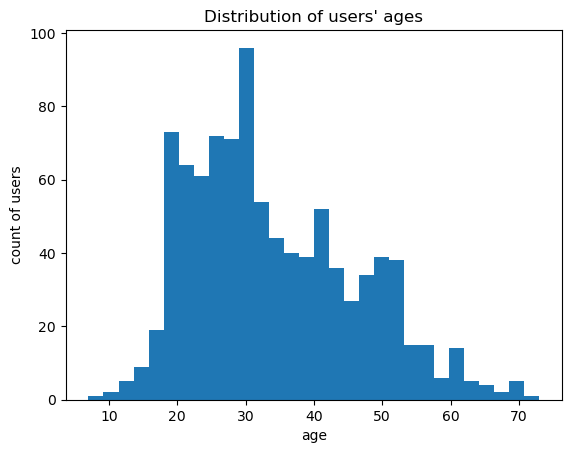

In [19]:
import matplotlib.pyplot as plt

users.age.plot.hist(bins=30)
plt.title("Distribution of users' ages")
plt.ylabel('count of users')
plt.xlabel('age');

### Data set preparation

앞에서 설명한 것처럼 FM은 고차원 데이터 세트에서 가장 잘 작동합니다. 결과적으로 사용자 ID와 영화 ID를 한 번에 인코딩할 것입니다 (타임스탬프는 무시하겠습니다). 따라서 데이터 세트의 각 샘플은 사용자 ID 및 동영상 ID와 관련하여 두 개의 값만 1로 설정된 2,625 Boolean 벡터 (943+1682) 가 됩니다.

바이너리 추천자를 만들 것입니다 (즉, 좋아요/마음에 들지 않음). 4 성급 및 5 성급 등급은 1로 설정됩니다.낮은 등급은 0으로 설정됩니다.

마지막으로, Amazon SageMaker에서 FM을 구현하려면 훈련 및 테스트 데이터를 protobuf 형식의 float32 텐서에 저장해야 한다는 것입니다.(예, 복잡하게 들립니다 🙂 그러나 Amazon SageMaker SDK는 이를 처리하는 편리한 유틸리티 기능을 제공하므로 너무 걱정하지 마십시오.)


### Highlevel Overview

구현해야 할 단계는 다음과 같습니다.

* 디스크에서 MovieLens 훈련 세트와 테스트 세트를 로드합니다.
* 각 세트에 대해 핫 인코딩된 데이터 샘플을 포함하는 sparse 행렬을 만듭니다.
* 각 세트에 대해 등급을 유지하는 레이블 벡터를 만듭니다.
* 두 세트를 모두 protobuf로 인코딩된 파일에 씁니다.
* 이러한 파일을 Amazon S3 버킷에 복사합니다.
* Amazon SageMaker에서 FM training 작업을 구성하고 실행합니다.
* 해당 모델을 엔드포인트에 배포합니다.
* 몇 가지 예측을 실행합니다.


In [20]:
# For each user, build a list of rated movies.
# We'd need this to add random negative samples.
moviesByUser = {}
for userId in range(nbUsers):
    moviesByUser[str(userId)]=[]

with open('./data/ml-100k/ua.base','r') as f:
    samples=csv.reader(f,delimiter='\t')
    for userId,movieId,rating,timestamp in samples:
        moviesByUser[str(int(userId)-1)].append(int(movieId)-1) 

In [21]:
def loadDataset(filename, lines, columns):
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((lines, columns)).astype('float32')
    # Labels are stored in a vector
    Y = []
    line=0
    with open(filename,'r') as f:
        samples=csv.reader(f,delimiter='\t')
        for userId,movieId,rating,timestamp in samples:
            X[line,int(userId)-1] = 1
            X[line,int(nbUsers)+int(movieId)-1] = 1
            if int(rating) >= 4:
                Y.append(1)
            else:
                Y.append(0)
            line=line+1
            
    Y=np.array(Y).astype('float32')
    return X,Y

* A training sparse matrix: 90,570 행과 2,625 열 (user ID 에 관련된 943 개의 원-핫 인코딩이 된 피쳐들과, movie ID 와 관련된 1682개의 원-핫 인코딩이 된 피쳐들)
* A training label array: 90,570 개의 등급
* A test sparse matrix: 9,430 개의 행과 2,625 열
* A test label array: 9,430 개의 등급

In [22]:
X_train, Y_train = loadDataset('./data/ml-100k/ua.base', nbRatingsTrain, nbFeatures)
X_test, Y_test = loadDataset('./data/ml-100k/ua.test',nbRatingsTest,nbFeatures)

In [23]:
print(X_train.shape)
print(Y_train.shape)
assert X_train.shape == (nbRatingsTrain, nbFeatures)
assert Y_train.shape == (nbRatingsTrain, )
zero_labels = np.count_nonzero(Y_train)
print("Training labels: %d zeros, %d ones" % (zero_labels, nbRatingsTrain-zero_labels))

print(X_test.shape)
print(Y_test.shape)
assert X_test.shape  == (nbRatingsTest, nbFeatures)
assert Y_test.shape  == (nbRatingsTest, )
zero_labels = np.count_nonzero(Y_test)
print("Test labels: %d zeros, %d ones" % (zero_labels, nbRatingsTest-zero_labels))

(90570, 2625)
(90570,)
Training labels: 49906 zeros, 40664 ones
(9430, 2625)
(9430,)
Test labels: 5469 zeros, 3961 ones


In [24]:
train_key      = 'train.protobuf'
train_prefix   = '{}/{}'.format(prefix, 'train3')

test_key       = 'test.protobuf'
test_prefix    = '{}/{}'.format(prefix, 'test3')

output_prefix  = 's3://{}/{}/output'.format(bucket, prefix)

### Convert to protobuf and save to S3

다음으로 train 세트와 test 세트를 Amazon S3 에 저장된 두 개의 protobuf 파일로 작성하겠습니다. 다행스럽게도 write_spmatrix_to_sparse_tensor() 유틸리티 함수를 사용할 수 있습니다. 샘플과 레이블을 인 메모리 protobuf 로 인코딩된 sparse 다차원 배열 (일명 텐서) 에 씁니다.

그런 다음 버퍼를 Amazon S3에 커밋합니다. 이 단계가 완료되면 데이터 준비가 완료되었으며 이제 training 작업에 집중할 수 있습니다.


In [25]:
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)
    
train_data = writeDatasetToProtobuf(X_train, Y_train, bucket, train_prefix, train_key)    
test_data  = writeDatasetToProtobuf(X_test, Y_test, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://sagemaker-us-east-1-654304825407/sagemaker/movielens/train3/train.protobuf
s3://sagemaker-us-east-1-654304825407/sagemaker/movielens/test3/test.protobuf
Output: s3://sagemaker-us-east-1-654304825407/sagemaker/movielens/output


### Run training job

AWS 리전에서 사용할 수 있는 FM 컨테이너를 기반으로 Estimator를 만드는 것부터 시작하겠습니다. 그런 다음 FM 전용 하이퍼파라미터([참조](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/fact-machines-hyperparameters.html))를 설정해야 합니다.

feature_dim: 각 샘플의 피처 수입니다 (이 경우 2,625개).
predictor_type: 'binary_classifier'를 사용할 것입니다.
num_factors: 사용자 및 항목 행렬의 공통 차원입니다 (게시물 시작 부분의 예제에서 설명).


In [26]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('factorization-machines', region=sess.boto_region_name, version='latest')
# container = sagemaker.amazon.amazon_estimator.get_image_uri(
#     boto3.Session().region_name, "factorization-machines", "latest")
print(container)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


382416733822.dkr.ecr.us-east-1.amazonaws.com/factorization-machines:1


In [27]:
# 학습 : 약 6분 소요
fm = sagemaker.estimator.Estimator(container,
                                   get_execution_role(), 
                                   instance_count=1, 
                                   instance_type='ml.m4.xlarge',
                                   output_path=output_prefix,
                                   sagemaker_session=sagemaker.Session())

fm.set_hyperparameters(feature_dim=nbFeatures,
                      predictor_type='binary_classifier',
                      mini_batch_size=1000,
                      num_factors=64,
                      epochs=10)

fm.fit({'train': train_data, 'test': test_data})  # 정확도 : 0.75

INFO:sagemaker:Creating training-job with name: factorization-machines-2023-05-20-14-06-23-906


2023-05-20 14:06:26 Starting - Starting the training job...
2023-05-20 14:06:52 Starting - Preparing the instances for training.........
2023-05-20 14:08:24 Downloading - Downloading input data...
2023-05-20 14:08:49 Training - Downloading the training image...............
2023-05-20 14:11:25 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/20/2023 14:11:46 INFO 140542589814592] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method': 'normal', 'bias_init_sigma': '0.01', 'linear_init_method': 'normal', 'linear_init_sigma': '0.01', 'factors_init_method': 'normal', 'factors_init_sigm

50 epoch 이후 테스트 정확도는 71.5% 이고 F1 점수 (이진 분류기의 일반적인 메트릭) 는 0.75입니다 (1은 완벽한 분류기를 나타냄) - 이는 매번 조금씩 달라질 수 있습니다. 좋지는 않지만 sparse 행렬과 protobuf 로 인해 하이퍼 파라미터를 조정하는 데 많은 시간을 소비하지 않았습니다.

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : binary_classification_accuracy

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : 0.7159

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : binary_classification_cross_entropy

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : 0.581087609863

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : binary_f_1.000

[01/29/2018 13:42:41 INFO 140015814588224] #test_score (algo-1) : 0.74558968389



### Deploy model


In [28]:
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer

class FMSerializer(JSONSerializer):
    def serialize(self, data):
       js = {'instances': []}
       for row in data:
              js['instances'].append({'features': row.tolist()})
       return json.dumps(js)

In [29]:
# 약 6 분 소요
from time import strftime, gmtime
timestamp = strftime('%d-%H-%M-%S', gmtime())

fm_predictor = fm.deploy(
    endpoint_name = 'movielens-{}'.format(timestamp),
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    serializer=FMSerializer(),
    deserializer= JSONDeserializer())

INFO:sagemaker:Creating model with name: factorization-machines-2023-05-20-14-12-50-873
INFO:sagemaker:Creating endpoint-config with name movielens-20-14-12-50
INFO:sagemaker:Creating endpoint with name movielens-20-14-12-50


----------!

### Run predictions


In [30]:
# 10개 영화에 대하여 바이너리 추천(좋아요:1 /마음에 들지 않음:0)
result = fm_predictor.predict(X_test[1000:1010].toarray(), initial_args={"ContentType": "application/json"})
print(result)
# print (Y_test[1000:1010])  # 실제 값 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

{'predictions': [{'score': 0.5666278600692749, 'predicted_label': 1.0}, {'score': 0.48668694496154785, 'predicted_label': 0.0}, {'score': 0.4943739175796509, 'predicted_label': 0.0}, {'score': 0.5673641562461853, 'predicted_label': 1.0}, {'score': 0.5373562574386597, 'predicted_label': 1.0}, {'score': 0.49052491784095764, 'predicted_label': 0.0}, {'score': 0.507140040397644, 'predicted_label': 1.0}, {'score': 0.5508791208267212, 'predicted_label': 1.0}, {'score': 0.5169398784637451, 'predicted_label': 1.0}, {'score': 0.49745112657546997, 'predicted_label': 0.0}]}
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [46]:
# 예측값 : 추천값
pred = np.array([(k['predicted_label']) for k in result['predictions']])
print(pred)
print (Y_test[1000:1010])  # 실제 값 : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

[1. 0. 0. 1. 1. 0. 1. 1. 1. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [31]:
# 모델 엔드포인트 삭제
# fm_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: movielens-20-14-12-50
INFO:sagemaker:Deleting endpoint with name: movielens-20-14-12-50
